# Exploitation - Label Prediction

In the exploitation task, we aim to predict the type of edges (transport routes). We start with Hand crafted features, followed by node embedding and finally use GNNs. In this notebook, we will work using the hand-crafted features.

## Task - 2

In the second task, we predict the edge labels between the given nodes. 

### Hand-crafted features

For this task we consider the following node features

1. In degree centrality
2. Out degree centrality
3. Betweenness centrality

and the following common features
1. fraction of common incoming neighbors among all incoming neighbors between the nodes
2. fraction of common outgoing neighbors among all outgoing neighbors between the nodes

To compute the edge features between nodes, we combine the node features by subtracting the source node features from the target node features and then add the edge features.

**Imports**

In [1]:
import glob
import pickle
import pathlib
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns

from enum import Enum
from tqdm import tqdm
from matplotlib import pyplot as plt
from typing import Union, List, Dict, Literal, Tuple

from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from skmultilearn.model_selection import iterative_train_test_split

**Paths for input and output**

In [2]:
rel_data_folder_path = pathlib.Path("./../../../data")
transport_data_path = rel_data_folder_path.joinpath('transport_data')
city_network = rel_data_folder_path.joinpath('network_graphs')
city_network_graphs = city_network.joinpath('graphs')
city_network_graphs_dir = city_network_graphs.joinpath('directed_graphs')
city_network_bones = city_network.joinpath('nodes-edges')

checkpoints_folder_path = rel_data_folder_path.joinpath("checkpoints")
city_network_graphs_dir_betweenness = checkpoints_folder_path.joinpath('directed_graphs_betweenness')
city_network_graphs_dir_label_pred_linreg = checkpoints_folder_path.joinpath('linreg-label-pred')
city_network_graphs_dir_label_pred_linreg_hco = city_network_graphs_dir_label_pred_linreg.joinpath('handcraft_only')
city_network_graphs_dir_label_pred_linreg_commono = city_network_graphs_dir_label_pred_linreg.joinpath('commonft_only')
city_network_graphs_dir_label_pred_linreg_all = city_network_graphs_dir_label_pred_linreg.joinpath('both')

rel_docs_folder_path = pathlib.Path("./../../../documents")
reports_folder_path = rel_docs_folder_path.joinpath("report")
tex_folder_path = reports_folder_path.joinpath("tex_files")
images_folder_path = tex_folder_path.joinpath("images")

**Utility Functions**

In [3]:
# Define enum for route types
class RouteType(Enum):
    """
    An enumeration class representing different types of routes.

    Possible values:
    - tram
    - subway
    - rail
    - bus
    - ferry
    - cablecar
    - gondola
    """
    tram, subway, rail, bus, ferry, cablecar, gondola = range(7)

def load_city_graphs(city_name, graphs_folder):
    """
    Load the graph representation of a city from a file.

    Args:
        city_name (str): The name of the city.
        graphs_folder (pathlib.Path): The folder where the graph files are located.

    Returns:
        nx.DiGraph: The directed graph representing the city.
    """
    with open(graphs_folder.joinpath(city_name.lower() + '.gpickle'), 'rb') as f:
        city_graph = pickle.load(f)
    return city_graph

def load_all_cities_graphs(cities: list[str], graphs_folder: pathlib.Path):
    """
    Load the graph representations of multiple cities.

    Args:
        cities (list[str]): A list of city names.
        graphs_folder (pathlib.Path): The folder where the graph files are located.

    Returns:
        dict: A dictionary mapping city names to their corresponding graph representations.
    """
    return {city: load_city_graphs(city, graphs_folder) for city in cities}

def generate_edge_feature_targets(graph: nx.Graph, num_targets: int=7, incl_node_fts: bool=True, incl_common_fts: bool=True) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate a node feature matrix for a given graph.

    Args:
        graph: The input graph.
        num_targets: Number of possible targets. It is 7 for the transport network. 
        incl_node_fts: Boolean to consider node features in creating the edge features
        incl_common_fts: Boolean to consider common outgoing and incoming neighbors) in creating the edge features

    Returns:
        edge_features: The edge features.
        targes: target vector of dimension with values of {0, 1} for each mode of transport

    """
    
    edge_features = []
    targets = []
    
    if incl_node_fts:
        in_degree_centrality = nx.in_degree_centrality(graph)
        out_degree_centrality = nx.out_degree_centrality(graph)
        betweenness_centrality = nx.get_node_attributes(graph, "betweenness")
    
    
    edges_unq = []

    for edge in graph.edges():
        if edge not in edges_unq:
            edges_unq.append(edge)
    
    for node1, node2 in edges_unq:
        # Get the incoming neighbors of the source node
        source_incoming = set(graph.predecessors(node1))
        # Get the outgoing neighbors of the source node
        source_outgoing = set(graph.successors(node1))
        node_1_feat, node_2_feat = [], []
        if incl_node_fts:
            node_1_feat = [
                in_degree_centrality[node1],
                out_degree_centrality[node1], 
                betweenness_centrality[node1]
            ]
            node_2_feat = [
                in_degree_centrality[node2],
                out_degree_centrality[node2], 
                betweenness_centrality[node2]
            ]
            
        edge_feature = np.subtract(node_2_feat, node_1_feat)
        
        if incl_common_fts:
            # Get the incoming neighbors of the target node
            target_incoming = set(graph.predecessors(node2))

            # Get the outgoing neighbors of the target node
            target_outgoing = set(graph.successors(node2))

            union_incoming = len(source_incoming.union(target_incoming))
            union_outgoing = len(source_outgoing.union(target_outgoing))

            if union_incoming == 0:
                frac_comm_incoming = 0
            else:
                frac_comm_incoming = len(source_incoming.intersection(target_incoming)) / union_incoming

            if union_outgoing == 0:
                frac_comm_outgoing = 0
            else:
                frac_comm_outgoing = len(source_outgoing.intersection(target_outgoing)) / union_outgoing
        
            edge_feature = np.concatenate((edge_feature, np.array([frac_comm_incoming, frac_comm_outgoing])))
            
        edge_features.append(edge_feature)
        edge_data = graph.get_edge_data(node1, node2)
        target = np.zeros(num_targets)
        for edge_attr in edge_data.values():
            target[edge_attr['route_type']] = 1
        targets.append(target)
        
    return np.array(edge_features), np.array(targets)


def classifier(features: np.ndarray, targets: np.ndarray, route_classes: List[int], feature_selection: bool=False, num_features: int=1, test_size: float=0.5, seed: int=0, verbose: bool=False, input_feature_names: List[str]=[], title: str='') -> Tuple[np.ndarray, float, float]:
    ''' 
    INPUT:
    features: feature matrix of dimensions (N, D) (N: number of samples; D: number of features) 
    targets: target vector of dimensions (N, ) (N: number of samples)
    route_classes: The classes of the route to consider for the given city.
    feature_selection: a flag for whether to use feature selction, bool
    num_features: number of features used from feature selection
    test_size: Size of the test set, float
    seed: please set to 0 for reproducibility
    verbose: print and plot result or not, bool
    input_feature_names: Names for the input features, None by default
    title: Title for the confusion matrix

    OUTPUT:
    cm: confusion matrix on the test set
    f1: weighted f1 score on the test set
    acc: accuracy score on the test set

    '''

    # Split the data into training and testing sets, with test_size
    np.random.seed(seed)
    X_train, y_train, X_test, y_test = iterative_train_test_split(features, targets, test_size=test_size)

    if feature_selection:
        ## Build and train the ML model, including feature selection, normalization and Support Vector Classifier. Select the k highest relevant features for the classification. 
        feature_selector = SelectKBest(f_classif, k=num_features)
        X_train_sel = feature_selector.fit_transform(X_train, y_train)
        clf = make_pipeline(StandardScaler(), MultiOutputClassifier(LogisticRegression(class_weight='balanced', random_state=seed)))
        clf.fit(X_train_sel, y_train)
        ## Print the scores for individual features.
        print("\nTo select the top {} features:".format(num_features))
        if not input_feature_names:
            input_feature_names = ["feature_{}".format(str(i)) for i in range(features.shape[1])]
        print("\tThe feature scorees are:")
        print("\t{}".format({ft_name:ft_score for ft_name, ft_score in zip(input_feature_names, feature_selector.scores_)}))
        print("\tThe selected features are {}".format(feature_selector.get_feature_names_out(input_features=input_feature_names)))
    else:
        ## Build and train the ML model, including normalization and Logi.
        clf = make_pipeline(StandardScaler(), MultiOutputClassifier(LogisticRegression(class_weight='balanced', random_state=seed)))
        clf.fit(X_train, y_train)

    # Use the model to predict the labels of the test data
    if feature_selection:
        X_test_sel = feature_selector.transform(X_test)
        y_pred = clf.predict(X_test_sel)
    else:
        y_pred = clf.predict(X_test)
    # Output the confusion matrix and weighted f1 score on the test set. Print the weighted f1 score and plot the confusion matrix if verbose
    # cm = metrics.confusion_matrix(y_test, y_pred)
    cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
    f1 = metrics.f1_score(y_test, y_pred, average='weighted')
    acc = metrics.accuracy_score(y_test, y_pred)

    if verbose:
        print("\t\tThe Weighted F1 score is {}".format(f1))
        print("\t\tThe Accuracy is {}".format(acc))
        disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[RouteType(idx).name for idx in route_classes])
        disp.plot()
        if title:
            disp.ax_.set_title(title)
        plt.show()
    return cm, f1, acc # type: ignore

def train_model(cities_graphs_dicts: Dict[str, Dict[str, Union[float, List[List[int]], nx.Graph]]], cities_routes: Dict[str, List[int]], results_path: pathlib.Path, incl_node_fts: bool, incl_common_fts: bool, test_size: float, seed: int, num_targets: int, route_type: str) -> None:
    '''
    INPUT:
    cities_graphs_dicts: dictionary with keys as city names and values as dictionaries with keys as route types and values as route graphs
    cities_routes: Dictionay with keys as city names and values as the classes of the route to consider for the given city.
    results_path: path to save the results
    incl_node_fts: Boolean to consider node features in creating the edge features
    incl_common_fts: Boolean to consider common outgoing and incoming neighbors) in creating the edge features
    test_size: size of the test set, float
    seed: please set to 0 for reproducibility
    num_targets: possible number of targets, which is the number of modes of transport (7)
    route_type: the mode of transport graph of city to use, we will use full graph.
    
    OUTPUT:
    None
    
    '''
    
    results_path.mkdir(parents=True, exist_ok=True)

    for city, city_graphs in tqdm(cities_graphs_dicts.items()):
        city_graphs_scores = {}
        if city in cities_routes:
            route_graph = city_graphs[route_type]

            features_edges, targets_edge_all = generate_edge_feature_targets(route_graph, num_targets,
                                                                                    incl_node_fts=incl_node_fts,
                                                                                    incl_common_fts=incl_common_fts)

            route_classes = cities_routes[city]
            targets_edge = targets_edge_all[:,route_classes]

            
            cm, f1score, accuracy = classifier(features_edges, targets_edge, route_classes,
                                    feature_selection=False, test_size=test_size,
                                    seed=seed, verbose=False)

            city_graphs_scores[route_type] = {"f1": f1score, "cm": cm, "acc": accuracy}
        else:
            city_graphs_scores[route_type] = {"f1": None, "cm": None, "acc": None}

        with open(results_path.joinpath('{}.gpickle'.format(city)), 'wb') as f:
            pickle.dump(city_graphs_scores, f, pickle.HIGHEST_PROTOCOL)
            
        print("Results saved")

def read_scores(results_path: pathlib.Path, modes_to_drop: List[str]) -> Tuple[Dict[str, Dict[str, Union[float, list[List[int]], nx.Graph]]], pd.DataFrame]:
    '''
    INPUT:
    results_path: path to read the results
    modes_to_drop: list of modes of transport to drop from the results
    
    OUTPUT:
    cities_graphs_scores: dictionary with keys as city names and values as dictionaries with keys as metric name and values as metrics
    cities_graphs_scores_df: dataframe with columns as city, route, metric name and metric value
    '''
    cities_reg = sorted([x.stem for x in results_path.glob('*.gpickle')])
    cities_graphs_scores = load_all_cities_graphs(cities_reg, results_path)
    cities_graphs_scores_df = pd.DataFrame.from_dict({(i,j): cities_graphs_scores[i][j] 
                           for i in cities_graphs_scores.keys() 
                           for j in cities_graphs_scores[i].keys()},
                       orient='index').reset_index(drop=False, names=['city', 'route'])
    
    if modes_to_drop:
        cities_graphs_scores_df = cities_graphs_scores_df[~cities_graphs_scores_df['route'].isin(modes_to_drop)]
    
    return cities_graphs_scores, cities_graphs_scores_df

def plot_cms(scores_dict: Dict[str, Dict[str, Union[float, List[List[int]], nx.Graph]]], mode: str, cities_routes=Dict[str, List[int]]) -> None:
    '''
    Input
    scores_dict: dictionary with keys as city names and values as dictionaries with keys as metric name and values as metric
    mode: The mode of transport to use in the title
    cities_routes: Dictionay with keys as city names and values as the classes of the route to consider for the given city.
    '''
    fig, axes = plt.subplots(5, 5, figsize=(16, 16), sharex=False, sharey=False)
    for idx, (city, city_scores_lr) in tqdm(enumerate(scores_dict.items())):

        row = int(idx / 5)
        col = idx % 5
        
        if city in cities_routes:
            labels = cities_routes[city]
            cm = city_scores_lr[mode]['cm']
            disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
            disp.plot(ax=axes[row][col], values_format='')
            disp.ax_.set_title(city)

    fig.suptitle('Confusion Matrix for {} networks edge prediction (LogReg)'.format(mode))
    fig.tight_layout()

def plot_scores(scores_df: pd.DataFrame, score_string: Literal["f1", "acc"]="f1", features: str="all"):
    '''
    Input
    scores_df: Scores dataframe with columns city, route, and one column each for the F1 score, ConfusionMatrix and Accuracy
    score_string: The score string to plot.
    features: The features used to generate the scores
    '''
    plt.figure(figsize=(8,6))
    # sns.scatterplot(data=scores_df, x="route", y=score_string, style="city", hue='city')
    ax = sns.scatterplot(data=scores_df, y="city", x=score_string, size=score_string, palette="colorblind")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2)
    plt.title('{} score of label prediction using {} features (LogReg)'.format(score_string.title(), features))
    plt.tight_layout()
    return plt.gcf()

**Setting the parameters**

In [4]:
seed = 0
test_size = 0.3
route_type = 'full'
num_targets = len(RouteType)

**Reading the graphs for all the cities**

In [5]:
cities = sorted([x.stem for x in city_network_graphs_dir.glob('*.gpickle')])
cities_graphs_dir = load_all_cities_graphs(cities, city_network_graphs_dir_betweenness)

Here we create a dictionary of transport route for each city. The key is the city name and the value is a list with the route ids according to the original dataset paper. We remove the cities with only one mode of transport and also the cablecar route.

In [6]:
cities_routes = {}
for city, city_graphs in cities_graphs_dir.items():
    routes_ = []
    for route_type, route_graph in city_graphs.items():
        if ((route_type in ['full', 'cablecar']) or (route_graph is None)):
            continue
        routes_.append(RouteType[route_type].value)
    if len(routes_) > 1:
        cities_routes[city] = routes_

## Modelling

Run the next cells to re run the training and save the accuracy, confusion matrix and the f1score. Otherwise, skip the next section and run the cell after it to load the saved scores.

We train a Multioutput Logistic Regression model for each city with 70:30 split of training and testing data while stratifying it based on the targets.

We run three experiments in this part. First, we only use the node features i.e. In degree centrality, Out degree centrality, Betweenness centrality and Katz centrality. Second, only using the common incoming and outgoing neighbours features and lastly, using all 6 features.

### Only using Node features.

In [ ]:
train_model(cities_graphs_dir, cities_routes, city_network_graphs_dir_label_pred_linreg_hco, incl_node_fts=True, incl_common_fts=False, test_size=test_size, seed=seed, num_targets=num_targets, route_type=route_type)

### Only using Common features.

In [ ]:
train_model(cities_graphs_dir, cities_routes, city_network_graphs_dir_label_pred_linreg_commono, incl_node_fts=False, incl_common_fts=True, test_size=test_size, seed=seed, num_targets=num_targets, route_type=route_type)

### Using all features.

In [ ]:
train_model(cities_graphs_dir, cities_routes, city_network_graphs_dir_label_pred_linreg_all, incl_node_fts=True, incl_common_fts=True, test_size=test_size, seed=seed, num_targets=num_targets, route_type=route_type)

## Results

- The results of cablecar are not inlcuded as there is only one city with three stops in that category.

### Only using Node features.

<Axes: xlabel='route', ylabel='city'>

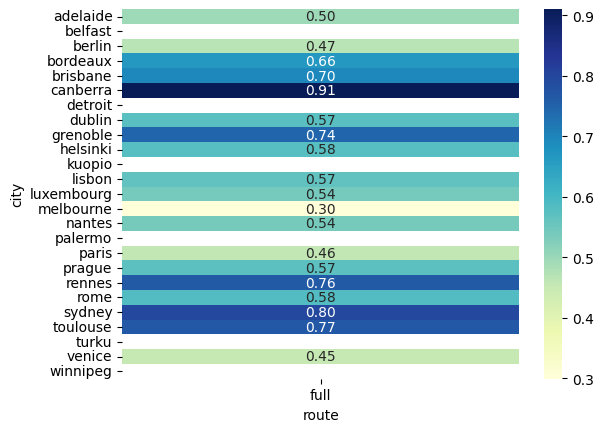

In [7]:
cities_graphs_scores_hco, cities_graphs_scores_hco_df = read_scores(city_network_graphs_dir_label_pred_linreg_hco, modes_to_drop=[])

sns.heatmap(cities_graphs_scores_hco_df.pivot(index='city', columns='route', values='f1'), cmap="YlGnBu", annot=True, fmt=".2f")

/var/folders/tv/cn6lr0qn6y96ztr8bjkmszkr0000gn/T/ipykernel_14894/3907009673.py:261: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(data=scores_df, y="city", x=score_string, size=score_string, palette="colorblind")
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


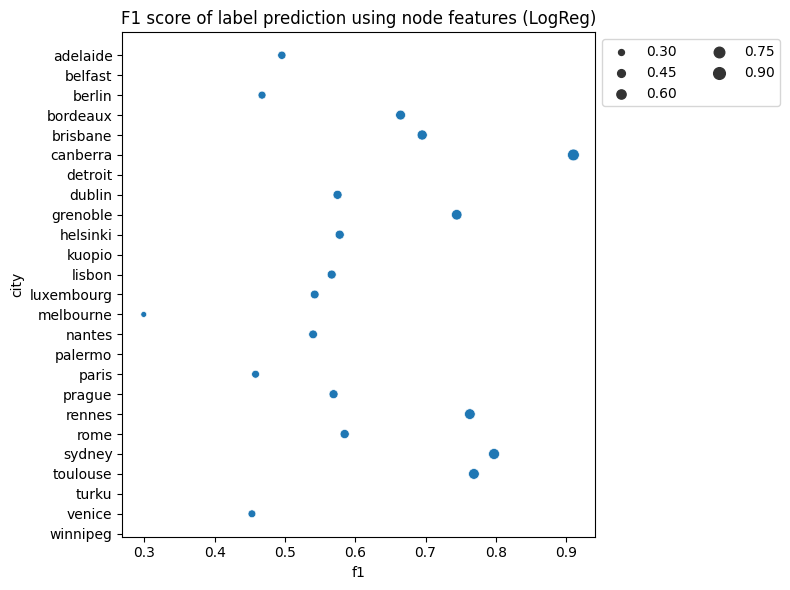

In [8]:
hco_fig = plot_scores(cities_graphs_scores_hco_df, features="node")

hco_fig.savefig(images_folder_path.joinpath('label-pred-hco.eps'), format='eps')

25it [00:00, 69.42it/s] 


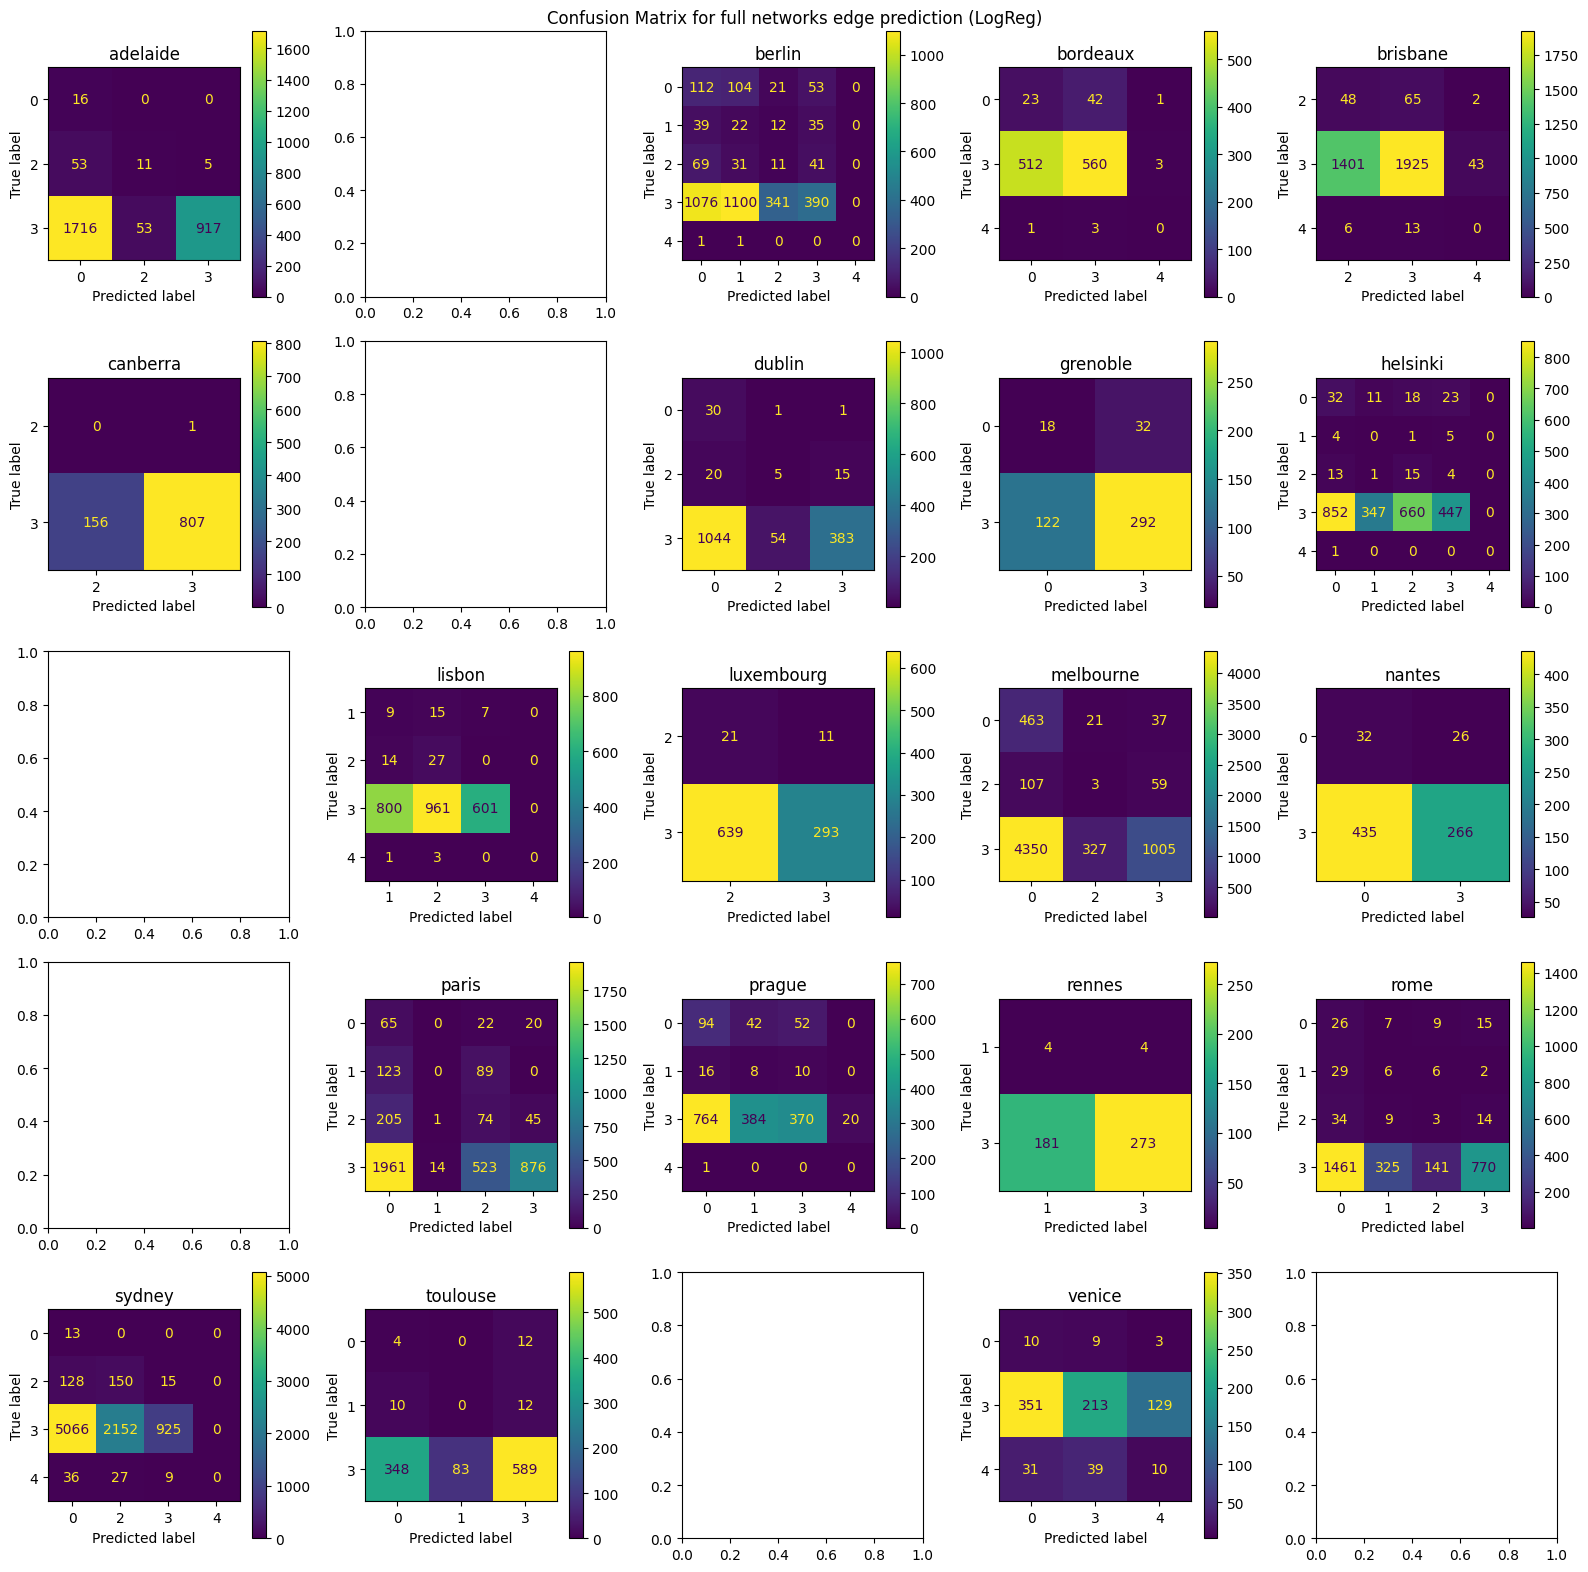

In [9]:
plot_cms(cities_graphs_scores_hco, mode='full', cities_routes=cities_routes)

For the task of label prediction, we compute the f1 score with the 'weighted' averaging method where the f1 score is computed for each label, and get their average weighted by the number of true instances for each label.

Similar to the edge prediction, we first try with node features only. Indegree centrality, outdegree centrality and betweenness centrality were used in this case. The f1 scores range from 0.3 to 0.91. Since the bus network label is the most common, we see that it is predicted often. Canberra achieves the highest score of 0.91. The city has two modes of transport (bus and rail). The bus network is made up of 2727 nodes and 3209 edges, and the rail network has only 3 nodes and 4 edges. Such heavy imbalance gives rise to the high average f1 score. Melbourne with three modes of transport - bus(13131 N, 18943 E), tram (219 N, 563 E) and rail (219 N and 563 E) has the least score of 0.3. The model is unable to capture the complexity of the problem with selected features.

### Only using Common features.

<Axes: xlabel='route', ylabel='city'>

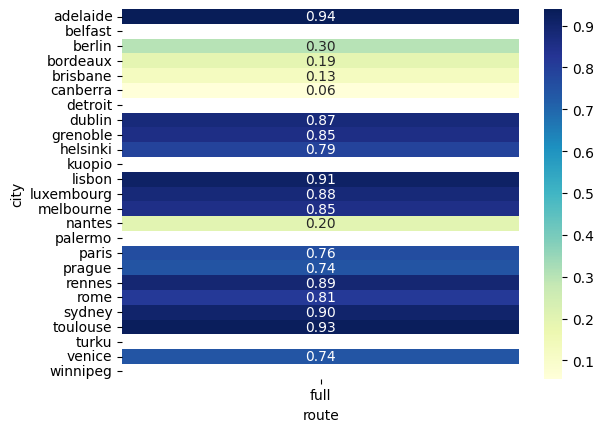

In [10]:
cities_graphs_scores_commono, cities_graphs_scores_commono_df = read_scores(city_network_graphs_dir_label_pred_linreg_commono, modes_to_drop=[])

sns.heatmap(cities_graphs_scores_commono_df.pivot(index='city', columns='route', values='f1'), cmap="YlGnBu", annot=True, fmt=".2f")

/var/folders/tv/cn6lr0qn6y96ztr8bjkmszkr0000gn/T/ipykernel_14894/3907009673.py:261: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(data=scores_df, y="city", x=score_string, size=score_string, palette="colorblind")
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


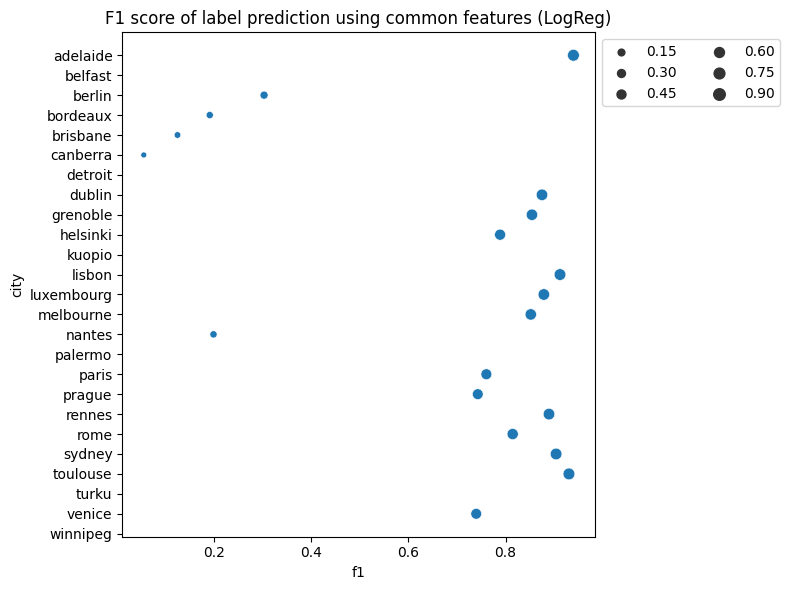

In [11]:
commono_fig = plot_scores(cities_graphs_scores_commono_df, features="common")

hco_fig.savefig(images_folder_path.joinpath('label-pred-commono.eps'), format='eps')

25it [00:00, 138.01it/s]


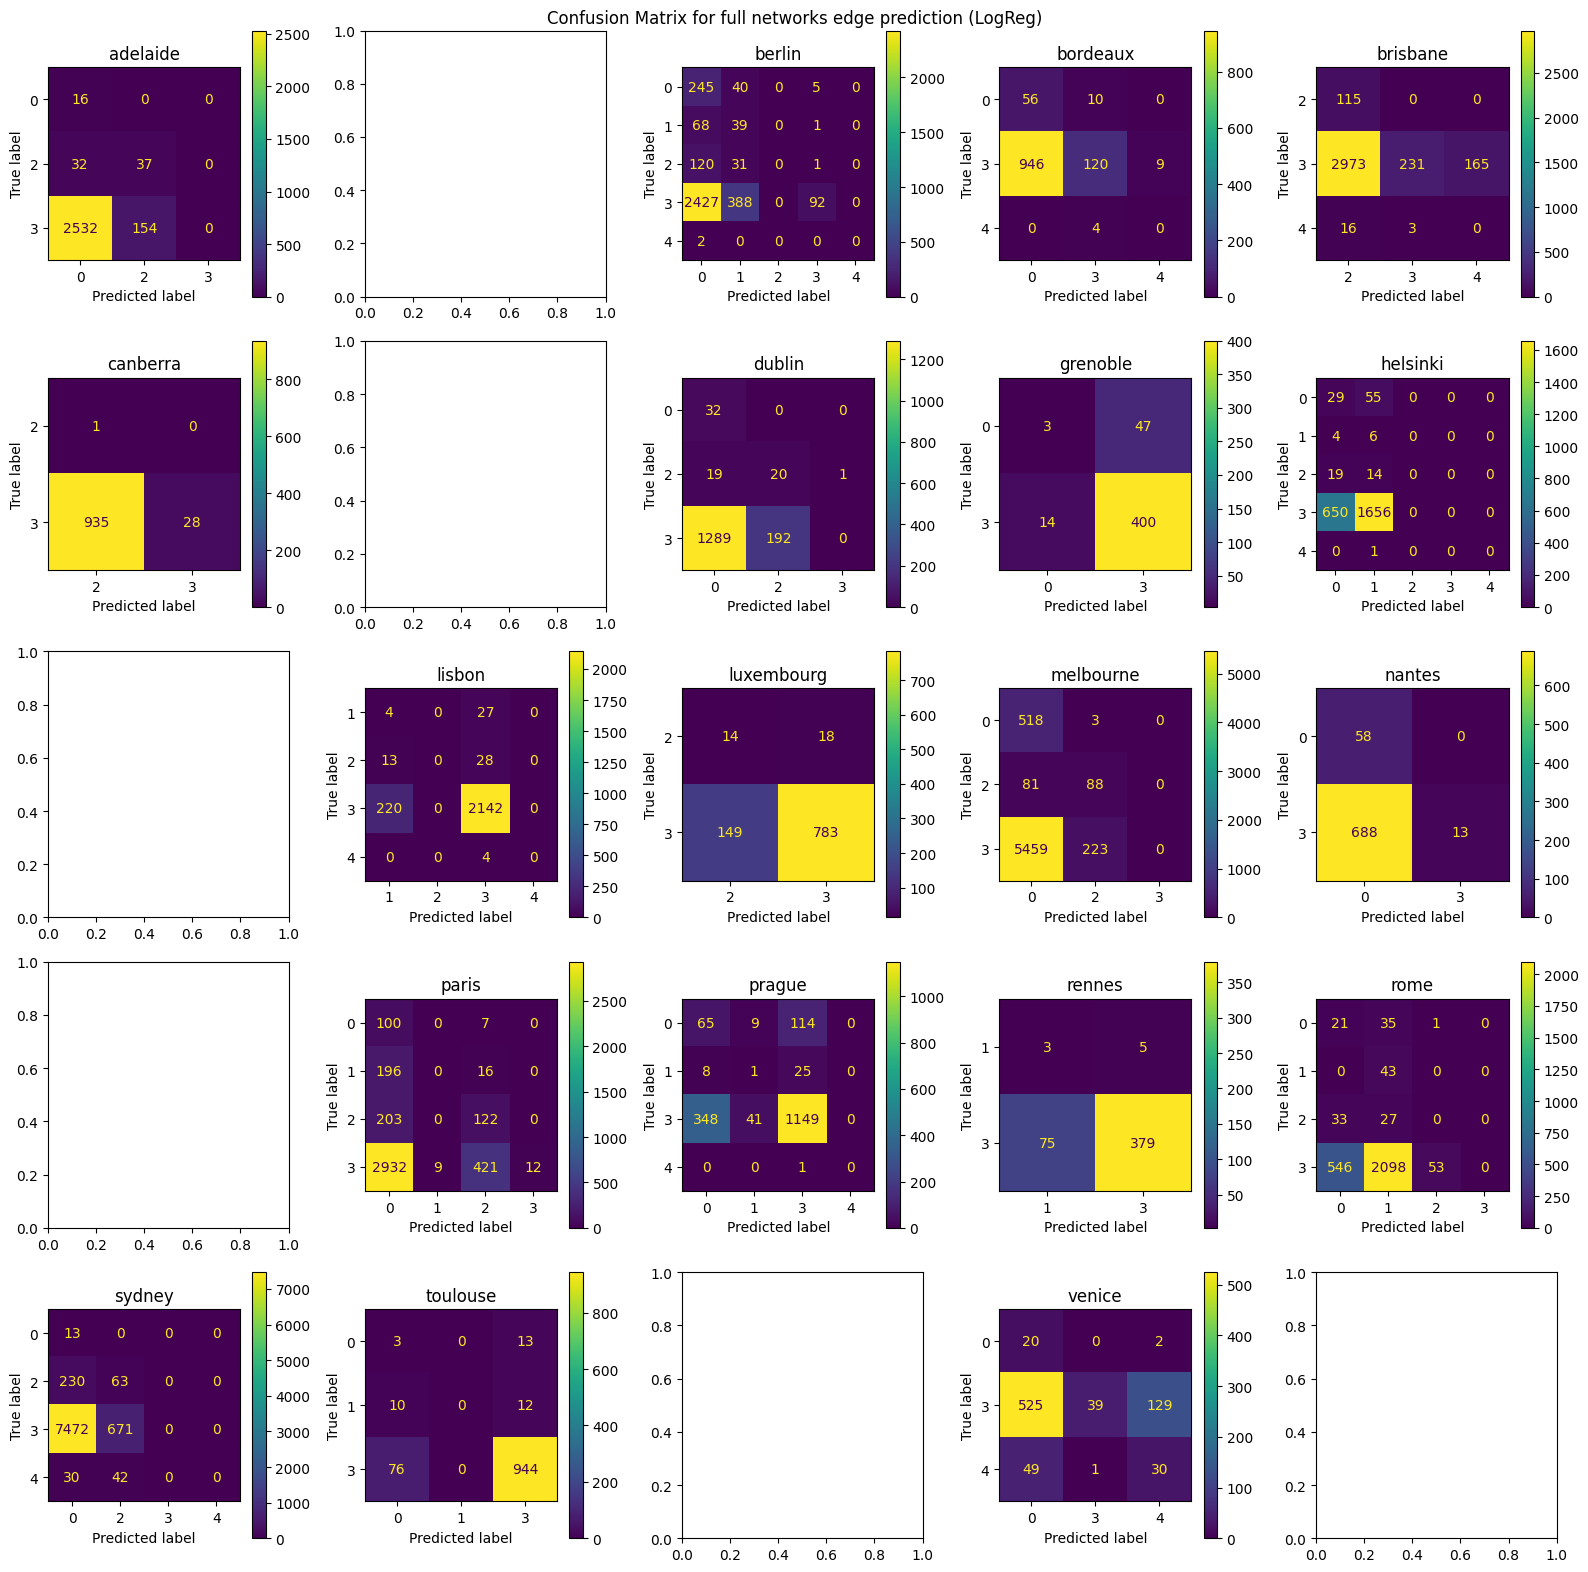

In [12]:
plot_cms(cities_graphs_scores_commono, mode='full', cities_routes=cities_routes)

In the second experiment, we use the common incoming and outgoing node features alone for label prediction. On average many cities achieve better performance than using the node features. The f1 scores lie between 0.06 and 0.94. Adelaide, Lisbon, Sydney and Toulouse have an f1 score greater than 0.9. Looking at the confusion matrix reveals the same problem as earlier i.e. weighted average of the score is high but the individual label performances are not good. Canberra has the lowest f1 score of 0.06 and the confusion matrix shows that 97% of the time, the rail label is predicted. A similar trend is seen in Brisbane which has the second least F1 score. Those cities with high scores predicted bus labels majorly and those with least scores did not.

### Using all features.

<Axes: xlabel='route', ylabel='city'>

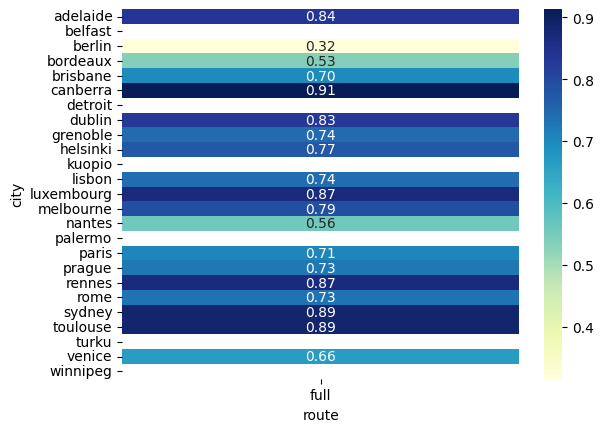

In [13]:
cities_graphs_scores_all, cities_graphs_scores_all_df = read_scores(city_network_graphs_dir_label_pred_linreg_all, modes_to_drop=[])

sns.heatmap(cities_graphs_scores_all_df.pivot(index='city', columns='route', values='f1'), cmap="YlGnBu", annot=True, fmt=".2f")

/var/folders/tv/cn6lr0qn6y96ztr8bjkmszkr0000gn/T/ipykernel_14894/3907009673.py:261: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(data=scores_df, y="city", x=score_string, size=score_string, palette="colorblind")
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


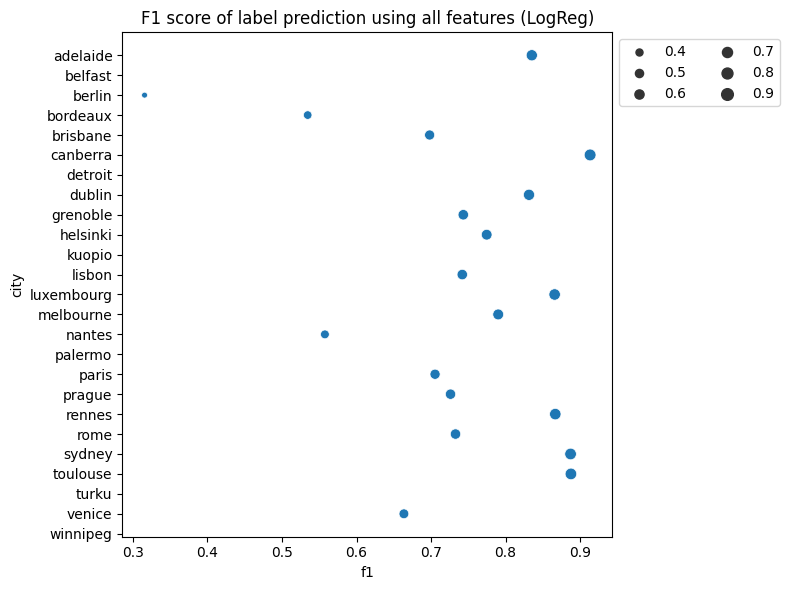

In [14]:
all_fig = plot_scores(cities_graphs_scores_all_df, features="all")

all_fig.savefig(images_folder_path.joinpath('label-pred-all.eps'), format='eps')

25it [00:00, 67.20it/s]


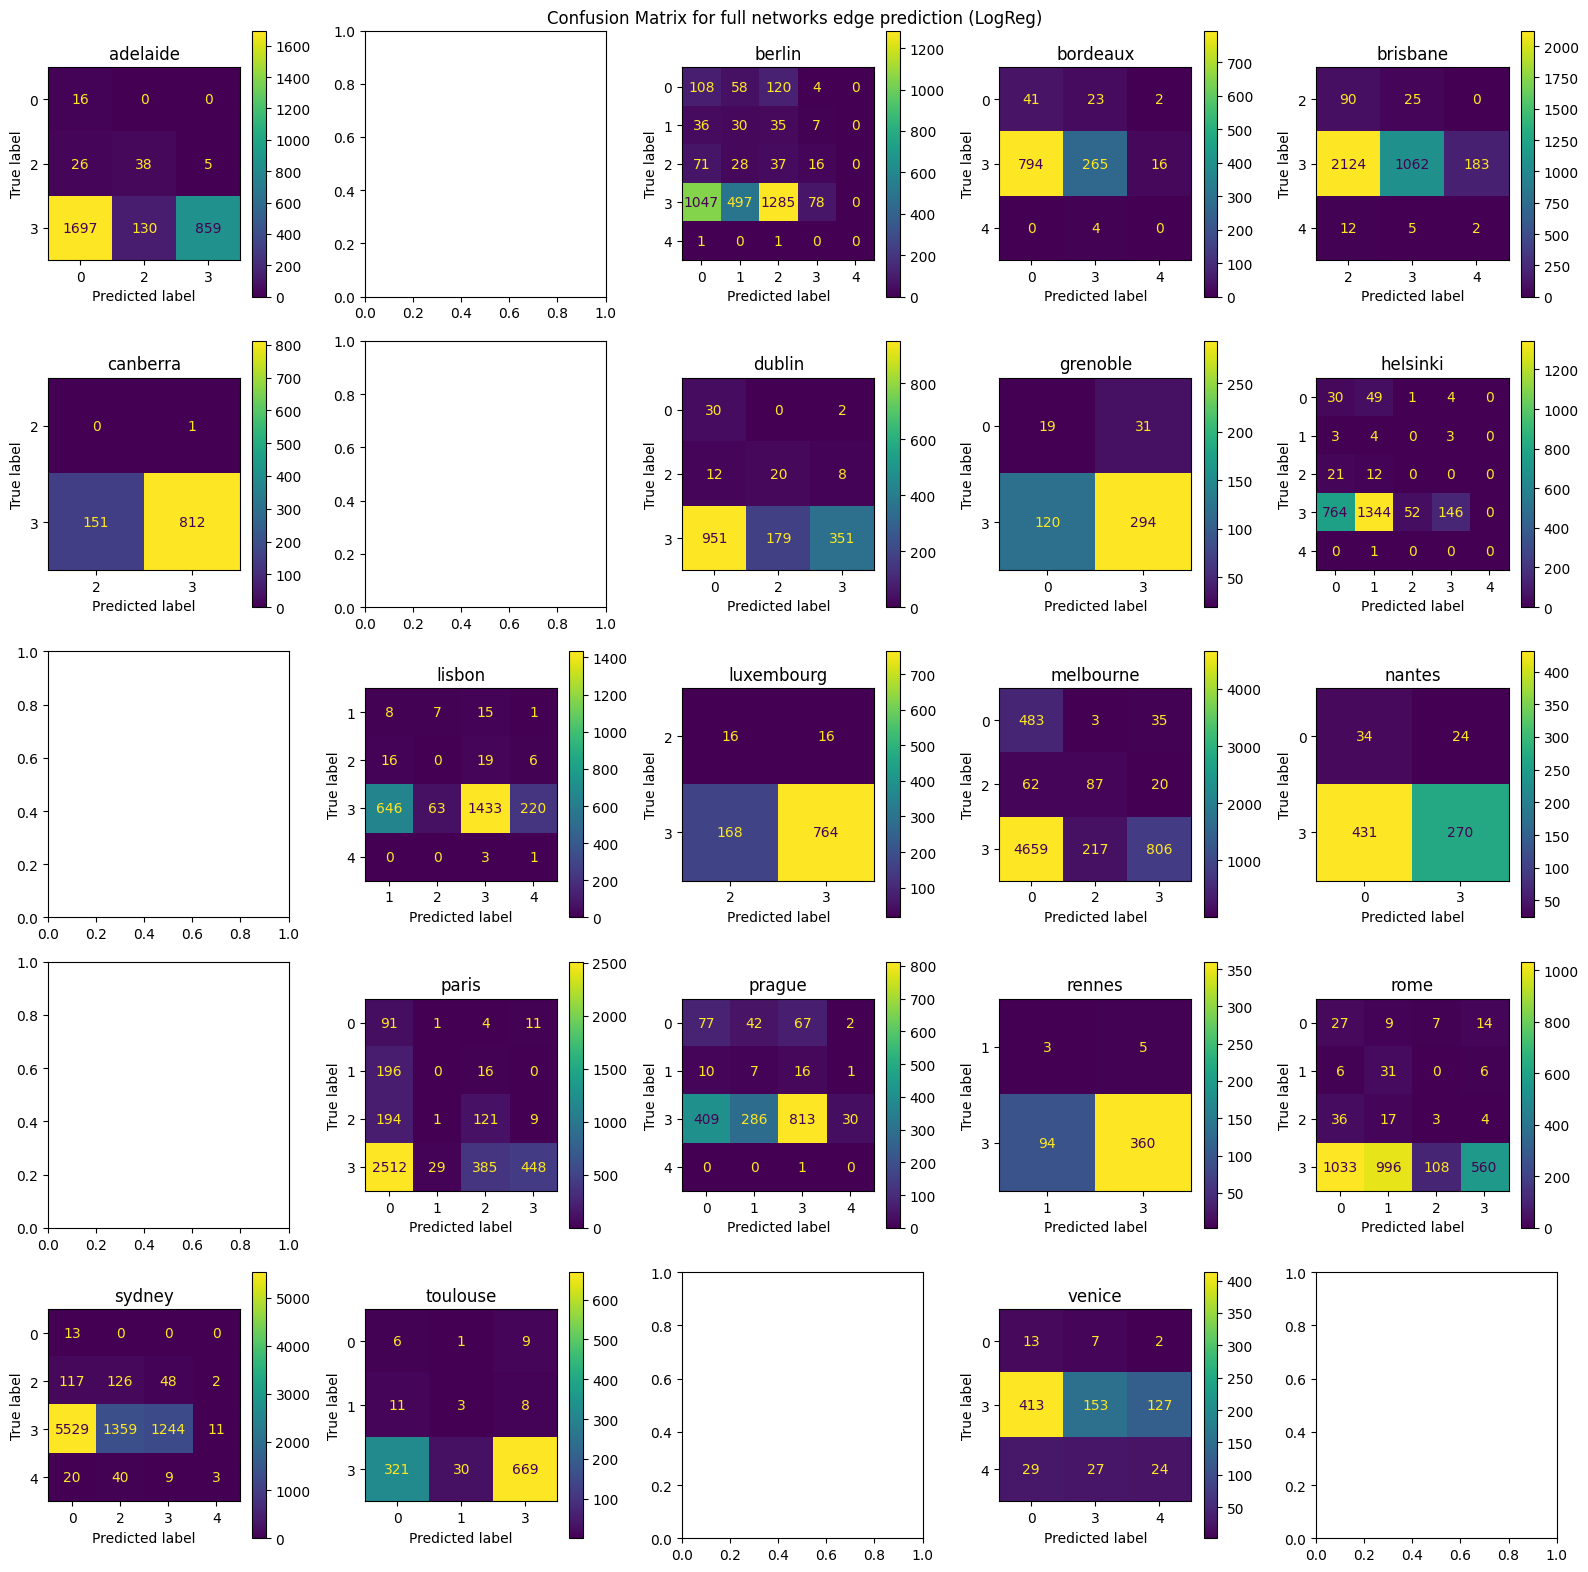

In [15]:
plot_cms(cities_graphs_scores_all, mode='full', cities_routes=cities_routes)

Lastly, when using both node and common features, the f1 score of all cities except Berlin which fared well on using only the common features shows a significant improvement. The f1 score of Berlin is 0.32, which is the least followed by 0.52 for Bordeaux, 0.66 for Venice and greater than 0.7 for the remaining. As expected the ability (inability) to predict (not predict) the bus label influenced the average score. Nevertheless, using both features creates a hybrid model with better than random performance.

In [16]:
combined_result_df = pd.merge(pd.merge(cities_graphs_scores_hco_df,cities_graphs_scores_commono_df,on = ['city', 'route'], suffixes=['_nodeo','_commono']),cities_graphs_scores_all_df,on = ['city', 'route'])[['city', 'route', 'f1_nodeo', 'f1_commono', 'f1']]
combined_result_df['best'] = combined_result_df[['f1_nodeo','f1_commono','f1']].idxmax(axis=1)
combined_result_df['best_score'] = combined_result_df[['f1_nodeo','f1_commono','f1']].max(axis=1)
combined_result_df

,city,route,f1_nodeo,f1_commono,f1,best,best_score
0,adelaide,full,0.495510,0.939301,0.835239,f1_commono,0.939301
1,belfast,full,NaN,NaN,NaN,NaN,NaN
2,berlin,full,0.467300,0.303658,0.315599,f1_nodeo,0.467300
3,bordeaux,full,0.664464,0.192045,0.534501,f1_nodeo,0.664464
4,brisbane,full,0.695234,0.125746,0.698122,f1,0.698122
5,canberra,full,0.910404,0.056452,0.913466,f1,0.913466
6,detroit,full,NaN,NaN,NaN,NaN,NaN
7,dublin,full,0.574778,0.874765,0.831477,f1_commono,0.874765
8,grenoble,full,0.744369,0.854132,0.743305,f1_commono,0.854132
9,helsinki,full,0.577838,0.788670,0.774681,f1_commono,0.788670


In [17]:
combined_result_df[["city", "route", "best"]].pivot(index='city', columns='route', values='best')

route,full
city,
adelaide,f1_commono
belfast,NaN
berlin,f1_nodeo
bordeaux,f1_nodeo
brisbane,f1
canberra,f1
detroit,NaN
dublin,f1_commono
grenoble,f1_commono


In [18]:
combined_result_df[["city", "route", "best", "best_score"]].pivot(index='city', columns='route', values='best_score')

route,full
city,
adelaide,0.939301
belfast,NaN
berlin,0.467300
bordeaux,0.664464
brisbane,0.698122
canberra,0.913466
detroit,NaN
dublin,0.874765
grenoble,0.854132


For the label prediction task, we considered 19 cities for the task which have more than one mode of transport. Not predicting the label, we only train the model to predict the possible modes of transport that exist between two nodes. For most of the cities (14 out of 19) the common features between the nodes provided the best performance. In the remaining 5 cities, the combined features performed well in Brisbane, Canberra and Nantes while the node features worked for Berlin and Bordeaux. The difference in f1 score was small between the node features and combined features in those cities where the combined features performed better.

In [21]:
combined_result_df

,city,route,f1_nodeo,f1_commono,f1,best,best_score
typing.Literal[<no_default>],,,,,,,
0,adelaide,full,0.495510,0.939301,0.835239,f1_commono,0.939301
1,belfast,full,NaN,NaN,NaN,NaN,NaN
2,berlin,full,0.467300,0.303658,0.315599,f1_nodeo,0.467300
3,bordeaux,full,0.664464,0.192045,0.534501,f1_nodeo,0.664464
4,brisbane,full,0.695234,0.125746,0.698122,f1,0.698122
5,canberra,full,0.910404,0.056452,0.913466,f1,0.913466
6,detroit,full,NaN,NaN,NaN,NaN,NaN
7,dublin,full,0.574778,0.874765,0.831477,f1_commono,0.874765
8,grenoble,full,0.744369,0.854132,0.743305,f1_commono,0.854132


In [35]:
t = pd.melt(combined_result_df, id_vars=['city', 'route'], value_vars=['f1_nodeo', 'f1_commono', 'f1'], var_name="Type of feature", value_name="f1_score")
t['Type of feature'].replace({'f1_nodeo' : 'Node Properties', 'f1_commono':'Common Features', 'f1':'Both'}, inplace=True)
t["f1_score"] = pd.to_numeric(t["f1_score"])
t

,city,route,Type of feature,f1_score
0,adelaide,full,Node Properties,0.495510
1,belfast,full,Node Properties,NaN
2,berlin,full,Node Properties,0.467300
3,bordeaux,full,Node Properties,0.664464
4,brisbane,full,Node Properties,0.695234
...,...,...,...,...
70,sydney,full,Both,0.887251
71,toulouse,full,Both,0.887725
72,turku,full,Both,NaN
73,venice,full,Both,0.663613


<Figure size 1200x1000 with 0 Axes>

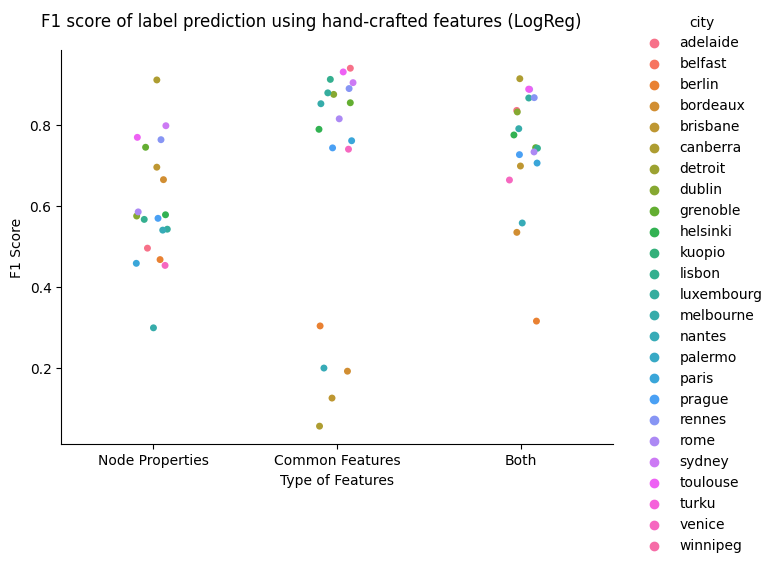

In [43]:
plt.figure(figsize=(12,10))
g = sns.catplot(t, y="f1_score", hue="city", x="Type of feature", sharey=True)
for ax in g.axes.flat:
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.yaxis.set_tick_params(labelbottom=True)

g.set_axis_labels("Type of Features", "F1 Score")
g.fig.suptitle("F1 score of label prediction using hand-crafted features (LogReg)")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1), ncols=1)
# sns.move_legend(g, "upper right", ncols=2)
plt.tight_layout()

plt.savefig(images_folder_path.joinpath('label-pred-all_combined.eps'), format='eps')